In [1]:
import numpy as np
from scipy.interpolate import splrep, splev
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [21]:
DATA_PATH = ("/Users/tamarajafar/Desktop/EE541/EE541_HW2/q1/raman.txt")

In [45]:
# read file and extract data
def load_raman_data(filename):
    wavenumbers = []
    intensities = []
    
    # Opening and reading the file
    with open(filename, 'r') as f:
        for line in f:
            # Split by tab or whitespace
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    wn = float(parts[0])  # wavenumber
                    intensity = float(parts[1])  # intensity
                    wavenumbers.append(wn)
                    intensities.append(intensity)
                except ValueError:
                    # Skip lines that can't be converted
                    continue
    
    return np.array(wavenumbers), np.array(intensities)

# Loading in the data
wavenumbers, intensities = load_raman_data('raman.txt')
print(f"Loaded {len(wavenumbers)} data points")
print(f"Wavenumber range: {wavenumbers[0]:.2f} to {wavenumbers[-1]:.2f} cm⁻¹")

# Show first few data points to verify
print("\nFirst 5 data points:")
for i in range(min(5, len(wavenumbers))):
    print(f"  {wavenumbers[i]:.2f} cm⁻¹: {intensities[i]:.2f}")

Loaded 7620 data points
Wavenumber range: 500.00 to 3500.00 cm⁻¹

First 5 data points:
  500.00 cm⁻¹: 294.38
  500.39 cm⁻¹: 288.92
  500.79 cm⁻¹: 286.07
  501.18 cm⁻¹: 275.22
  501.58 cm⁻¹: 275.12


In [46]:
# Step 2: Find peaks in the raw data
# The 'find_peaks' function finds local maxima
# We use 'prominence' to only find significant peaks
peaks, properties = find_peaks(intensities, prominence=np.max(intensities)*0.05)

# Get the peak wavenumbers and intensities
peak_wavenumbers = wavenumbers[peaks]
peak_intensities = intensities[peaks]

print(f"Found {len(peaks)} peaks initially")

# Sort peaks by intensity (largest first) and get top 8
sorted_indices = np.argsort(peak_intensities)[::-1]  # [::-1] reverses to get largest first
top8_indices = sorted_indices[:8]
top8_peaks = peaks[top8_indices]
top8_wavenumbers = peak_wavenumbers[top8_indices]
top8_intensities = peak_intensities[top8_indices]

print("\nTop 8 peaks (rough estimates):")
for i, (wn, intensity) in enumerate(zip(top8_wavenumbers, top8_intensities)):
    print(f"  {i+1}. {wn:.1f} cm⁻¹ (intensity: {intensity:.1f})")

Found 12 peaks initially

Top 8 peaks (rough estimates):
  1. 750.4 cm⁻¹ (intensity: 15275.1)
  2. 1250.9 cm⁻¹ (intensity: 5203.3)
  3. 2975.9 cm⁻¹ (intensity: 4767.2)
  4. 2948.0 cm⁻¹ (intensity: 4266.7)
  5. 2884.6 cm⁻¹ (intensity: 3785.1)
  6. 1032.0 cm⁻¹ (intensity: 3351.6)
  7. 1427.3 cm⁻¹ (intensity: 3219.4)
  8. 1145.4 cm⁻¹ (intensity: 2840.9)


In [47]:
# Step 3: Refine peak locations
# For each peak, look at a small region around it and fit a smooth curve (spline)
# Then find the exact maximum of that smooth curve

def refine_peak(wavenumbers, intensities, peak_idx, width=20):
    """
    Refine a peak location using spline interpolation
    
    peak_idx: index of the peak in the data
    width: how many points on each side to include
    """
    # Define region of interest
    start = max(0, peak_idx - width)
    end = min(len(wavenumbers), peak_idx + width + 1)
    
    # Extract region
    wn_region = wavenumbers[start:end]
    int_region = intensities[start:end]
    
    # Fit a spline (smooth curve) through the data
    spline = splrep(wn_region, int_region, k=3)  # k=3 means cubic spline
    
    # Create fine grid for evaluation
    wn_fine = np.linspace(wn_region[0], wn_region[-1], 1000)
    int_fine = splev(wn_fine, spline)
    
    # Find maximum
    max_idx = np.argmax(int_fine)
    refined_wavenumber = wn_fine[max_idx]
    refined_intensity = int_fine[max_idx]
    
    return refined_wavenumber, refined_intensity, wn_fine, int_fine

# Refine all top 8 peaks
refined_wavenumbers = []
refined_intensities = []
refined_data = []

for peak_idx in top8_peaks:
    ref_wn, ref_int, wn_fine, int_fine = refine_peak(wavenumbers, intensities, peak_idx)
    refined_wavenumbers.append(ref_wn)
    refined_intensities.append(ref_int)
    refined_data.append((wn_fine, int_fine))

refined_wavenumbers = np.array(refined_wavenumbers)
refined_intensities = np.array(refined_intensities)

# Sort by intensity (largest first)
sorted_indices = np.argsort(refined_intensities)[::-1]
refined_wavenumbers = refined_wavenumbers[sorted_indices]
refined_intensities = refined_intensities[sorted_indices]

print("\nRefined Top 8 Peak Wavenumbers (sorted by intensity):")
for i, wn in enumerate(refined_wavenumbers):
    print(f"{wn:.2f}")


Refined Top 8 Peak Wavenumbers (sorted by intensity):
750.25
1251.07
2975.78
2947.86
2884.51
1031.92
1427.42
1145.48


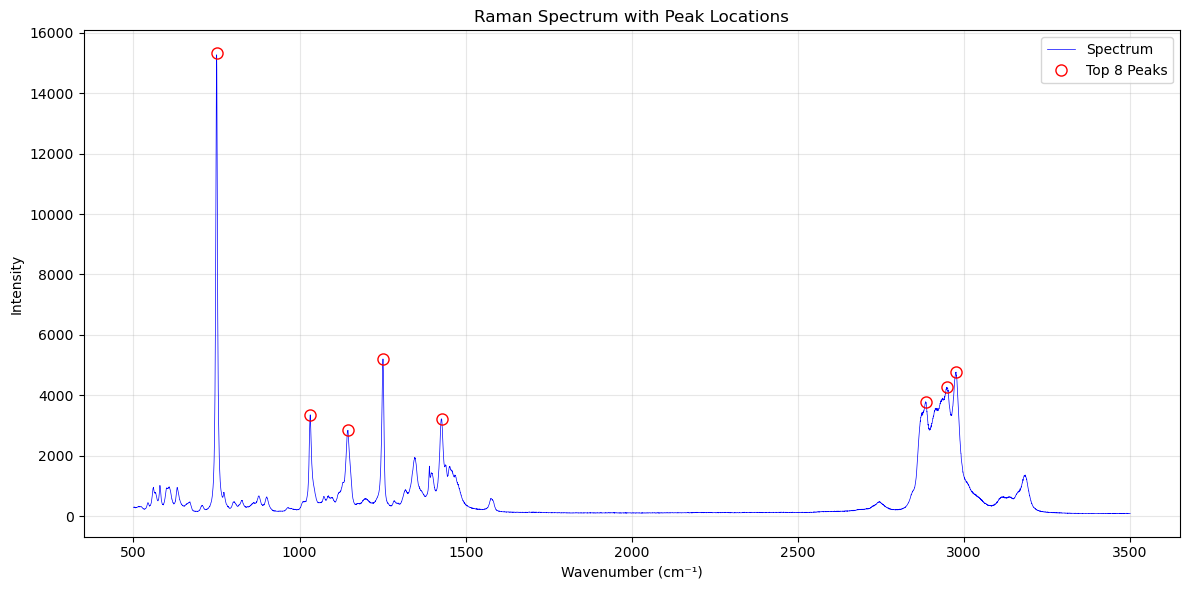

In [49]:
# Step 4a Full spectrum with peaks marked
plt.figure(figsize=(12, 6))
plt.plot(wavenumbers, intensities, 'b-', linewidth=0.5, label='Spectrum')
plt.plot(refined_wavenumbers, refined_intensities, 'ro', 
         markersize=8, markerfacecolor='none', linewidth=2, label='Top 8 Peaks')
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Intensity')
plt.title('Raman Spectrum with Peak Locations')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('q1_full_spectrum.pdf')
plt.show()

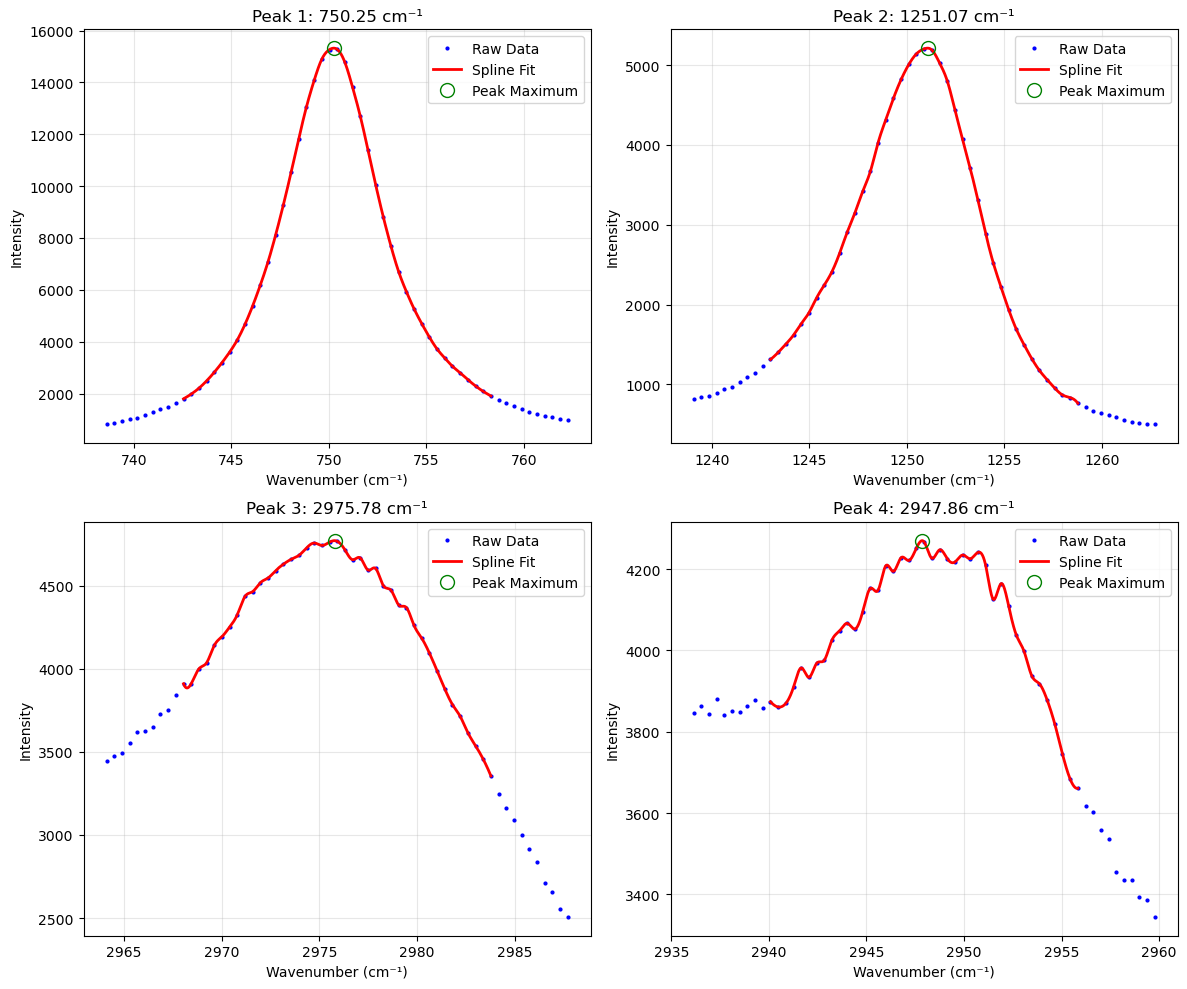

In [50]:
# Step 4b: zoomed in views of top 4 peaks
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    peak_idx = top8_peaks[sorted_indices[i]]
    
    # Get region around this peak
    ref_wn, ref_int, wn_fine, int_fine = refine_peak(wavenumbers, intensities, peak_idx)
    
    # Plot raw data in region
    start = max(0, peak_idx - 30)
    end = min(len(wavenumbers), peak_idx + 31)
    ax.plot(wavenumbers[start:end], intensities[start:end], 'b.', 
            markersize=4, label='Raw Data')
    
    # Plot spline interpolation
    ax.plot(wn_fine, int_fine, 'r-', linewidth=2, label='Spline Fit')
    
    # Mark the maximum
    ax.plot(refined_wavenumbers[i], refined_intensities[i], 'go', 
            markersize=10, markerfacecolor='none', linewidth=2, label='Peak Maximum')
    
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Peak {i+1}: {refined_wavenumbers[i]:.2f} cm⁻¹')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('q1_zoom_peaks.pdf')
plt.show()